# Gaussian Process Regression

## Theoretic Foundation

$\renewcommand{\bm}[1]{{\boldsymbol{\mathbf{#1}}}}$

Given a dataset $\mathcal{D} = \{X, y\} = \{\{\bm{x}_1,\dots,\bm{x}_n\},(y(\bm{x}_1),\dots,y(\bm{x}_n))^{\top}\} $ of $n$ input vectors of dimension $D$ and an $n \times 1$ vector of targets. Define a function
$$f(\bm{x}) \sim \mathcal{GP}(\mu,k_{\bm{\gamma}}),$$
then any
collection of function values $\bm{f}$ has a joint Gaussian
distribution,
\begin{align}
 \bm{f} = f(X) = [f(\bm{x}_1),\dots,f(\bm{x}_n)]^{\top} \sim \mathcal{N}(\bm{\mu},K_{X,X})
\end{align}
with a mean vector, $\bm{\mu}_i = \mu(x_i)$, and covariance matrix, $(K_{X,X})_{ij} = k_\bm{\gamma}(\bm{x}_i,\bm{x}_j)$, 
determined from the mean function and covariance kernel of the Gaussian process, $k_{\bm{\gamma}}$, is parametrized by $\bm{\gamma}$. \newline
Assuming additive Gaussian noise on the distribution of the function values, $$y(\bm{x})|f(\bm{x}) \sim \mathcal{N}(y(\bm{x}); f(\bm{x}),\sigma^2),$$
yields the predictive distribution of the GP evaluated at the
$n_*$ test points indexed by $X_*$, is given by
\begin{align}
 \bm{f}_*|X_*,&X,\bm{y},\bm{\gamma},\sigma^2 \sim \mathcal{N}(\mathbb{E}[\bm{f}_*],\text{cov}(\bm{f}_*)) \\
 \mathbb{E}[\bm{f}_*] &= \bm{\mu}_{X_*}  + K_{X_*,X}[K_{X,X}+\sigma^2 I]^{-1}\bm{y} \\
 \text{cov}(\bm{f}_*) &= K_{X_*,X_*} - K_{X_*,X}[K_{X,X}+\sigma^2 I]^{-1}K_{X,X_*} \\
\end{align}
$K_{X_*,X}$, for example, is an $n_* \times n$ matrix of covariances between
the GP evaluated at $X_*$ and $X$.   $\bm{\mu}_{X_*}$ is the $n_* \times 1$ mean vector,
and $K_{X,X}$ is the $n \times n$ covariance
matrix evaluated at training inputs~$X$.\newline

The structure of our data is discovered through learning interpretable kernel hyperparameters.  The marginal likelihood of the targets $\bm{y}$, the probability of the data conditioned only on kernel hyperparameters $\bm{\gamma}$, provides a principled probabilistic framework for kernel learning:
\begin{equation}
 \log p(\bm{y} | \bm{\gamma}, X) \propto -[\bm{y}^{\top}(K_{\bm{\gamma}}+\sigma^2 I)^{-1}\bm{y} + \log|K_{\bm{\gamma}} + \sigma^2 I|] \\
\end{equation}
where we have used $K_{\bm{\gamma}}$ as shorthand for $K_{X,X}$ given~$\bm{\gamma}$. 
Kernel learning can be achieved by optimizing Eq.~\eqref{eqn: mlikeli} with respect to $\bm{\gamma}$.\newline

The computational bottleneck for inference is solving the linear system
$(K_{X,X}+\sigma^2 I)^{-1}\bm{y}$, and for kernel learning is computing
the log determinant $\log|K_{X,X}+ \sigma^2 I|$ in the marginal likelihood.  
The standard approach is to compute the Cholesky decomposition of the
$n \times n$ matrix $K_{X,X}$, which
requires $\mathcal{O}(n^3)$ operations and $\mathcal{O}(n^2)$ storage.
After inference is complete, the predictive mean costs $\mathcal{O}(n)$,
and the predictive variance costs $\mathcal{O}(n^2)$, per test point
$\bm{x}_*$.

## Imports

In [12]:
import os
import sys

# required to make the path visible to import the tools
# this will change in public notebooks to be "pip install uq-regression-box"
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
nb_dir

import tempfile

import numpy as np
import gpytorch
import matplotlib.pyplot as plt
import torch
from lightning.pytorch import seed_everything
from tqdm import trange

from uq_method_box.datamodules import ToyHeteroscedasticDatamodule
from uq_method_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions,
    plot_toy_data,
)

plt.rcParams["figure.figsize"] = [14, 5]


In [5]:
seed_everything(0)  # seed everything for reproducibility

Global seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [6]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [7]:
dm = ToyHeteroscedasticDatamodule()

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

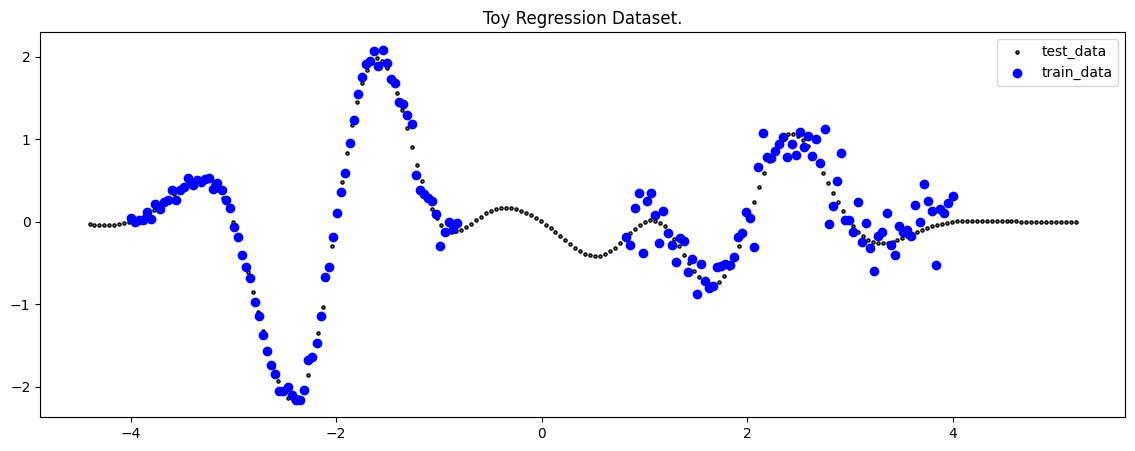

In [8]:
plot_toy_data(X_train, y_train, X_test, y_test)

## Model

In [9]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [11]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# init with batch from 
gp_model = ExactGPModel(X_train.squeeze(), y_train.squeeze(), likelihood)

# Find optimal model hyperparameters
gp_model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(gp_model.parameters(), lr=1e-2)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

bar = trange(100)
for i in bar:
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = gp_model(X_train.squeeze())
    # Calc loss and backprop gradients
    loss = -mll(output, y_train.squeeze())
    loss.backward()
    optimizer.step()
    bar.set_postfix(loss=f"{loss.detach().cpu().item()}")       

100%|██████████| 100/100 [00:01<00:00, 59.99it/s, loss=0.5715134143829346]


## Prediction

In [13]:
gp_model.eval()
likelihood.eval()

with torch.no_grad():
  gp_preds = gp_model(X_test.cpu())

gp_mean = gp_preds.mean.detach().cpu().numpy()
gp_var = gp_preds.variance.detach().cpu().numpy()
gp_covar = gp_preds.covariance_matrix.detach().cpu().numpy()

## Evaluate Predictions

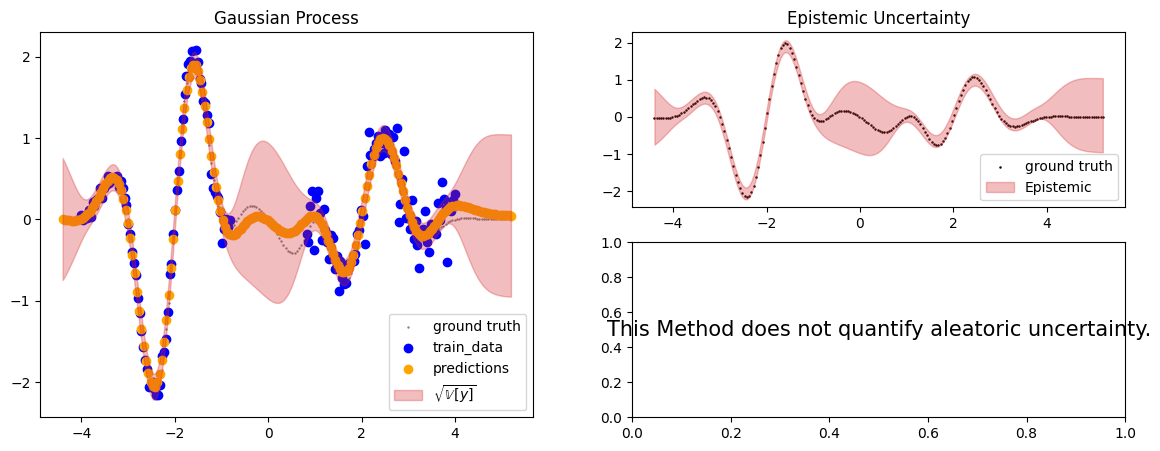

In [14]:
fig = plot_predictions(
    X_train,
    y_train,
    X_test,
    y_test,
    gp_mean,
    np.sqrt(gp_var),
    epistemic=np.sqrt(gp_var),
    title="Gaussian Process",
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction. For a discussion of why this is important, see ...

<Figure size 1400x500 with 0 Axes>

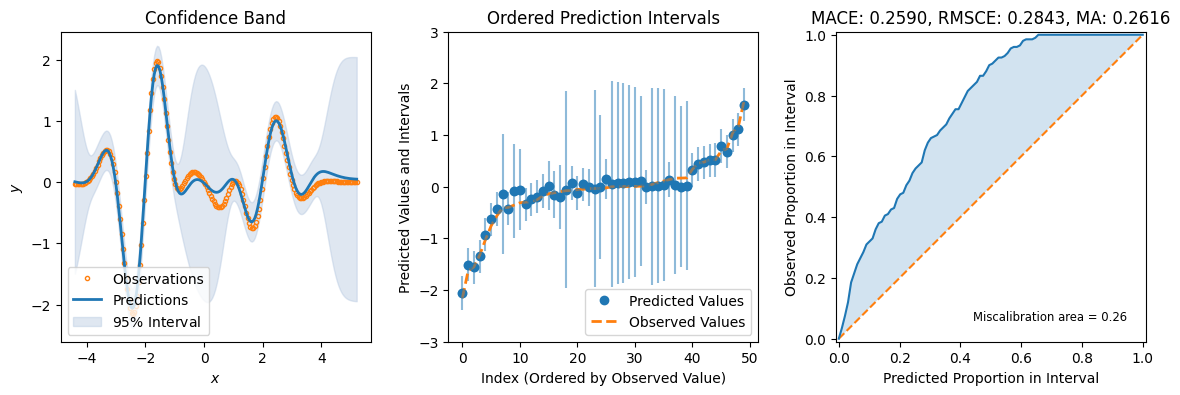

In [15]:
fig = plot_calibration_uq_toolbox(
    gp_mean, np.sqrt(gp_var), y_test.cpu().numpy(), X_test.cpu().numpy()
)

## Additional Resources

Links to othere related literature that might be interesting.